# Predicción de ingreso hospitalario en urgencias (clasificación binaria)
Objetivo: predecir ingreso (sí/no) usando variables demográficas, signos vitales y triage.
Relevancia clínica: priorizar recall en “Ingreso” para no dejar pasar pacientes graves.
Decisión de outcome: Disposition 1/4/6 = Egreso (0), 2/3/5/7 = Ingreso (1).

Dataset extraído desde https://www.kaggle.com/datasets/ilkeryildiz/emergency-service-triage-application/data

In [1]:
# =============== 2) Imports, configuración y reproducibilidad ===============
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings; warnings.filterwarnings("ignore")
np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import sklearn
print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("sklearn:", sklearn.__version__)



Python: 3.13.5
pandas: 2.3.2
numpy: 2.3.3
sklearn: 1.7.2


## Datos
Fuente: CSV provisto (latin-1, separador ;).
Notas: varias variables numéricas venían como texto; varias categóricas son códigos, van descritas en informe.

Dimensiones: (1267, 24)
Columnas: ['Group', 'Sex', 'Age', 'Patients number per hour', 'Arrival mode', 'Injury', 'Chief_complain', 'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP', 'HR', 'RR', 'BT', 'Saturation', 'KTAS_RN', 'Diagnosis in ED', 'Disposition', 'KTAS_expert', 'Error_group', 'Length of stay_min', 'KTAS duration_min', 'mistriage']


,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,...,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage
0,2,2,71,3,3,2,right ocular pain,1,1,2,...,36.6,100,2,Corneal abrasion,1,4,2,86,"5,00",1
1,1,1,56,12,3,2,right forearm burn,1,1,2,...,36.5,NaN,4,"Burn of hand, firts degree dorsum",1,5,4,64,"3,95",1
2,2,1,68,8,2,2,"arm pain, Lt",1,1,2,...,36.6,98,4,"Fracture of surgical neck of humerus, closed",2,5,4,862,"1,00",1


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Group,1267.0,NaN,NaN,NaN,1.456985,0.498343,1.0,1.0,1.0,2.0,2.0
Sex,1267.0,NaN,NaN,NaN,1.521705,0.499726,1.0,1.0,2.0,2.0,2.0
Age,1267.0,NaN,NaN,NaN,54.423836,19.725033,16.0,37.0,57.0,71.0,96.0
Patients number per hour,1267.0,NaN,NaN,NaN,7.519337,3.160563,1.0,5.0,7.0,10.0,17.0
Arrival mode,1267.0,NaN,NaN,NaN,2.820837,0.807904,1.0,2.0,3.0,3.0,7.0
Injury,1267.0,NaN,NaN,NaN,1.192581,0.394482,1.0,1.0,1.0,1.0,2.0
Chief_complain,1267,417,abd pain,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mental,1267.0,NaN,NaN,NaN,1.105762,0.447768,1.0,1.0,1.0,1.0,4.0
Pain,1267.0,NaN,NaN,NaN,0.563536,0.496143,0.0,0.0,1.0,1.0,1.0
NRS_pain,1267,11,#BOÞ!,556,NaN,NaN,NaN,NaN,NaN,NaN,NaN


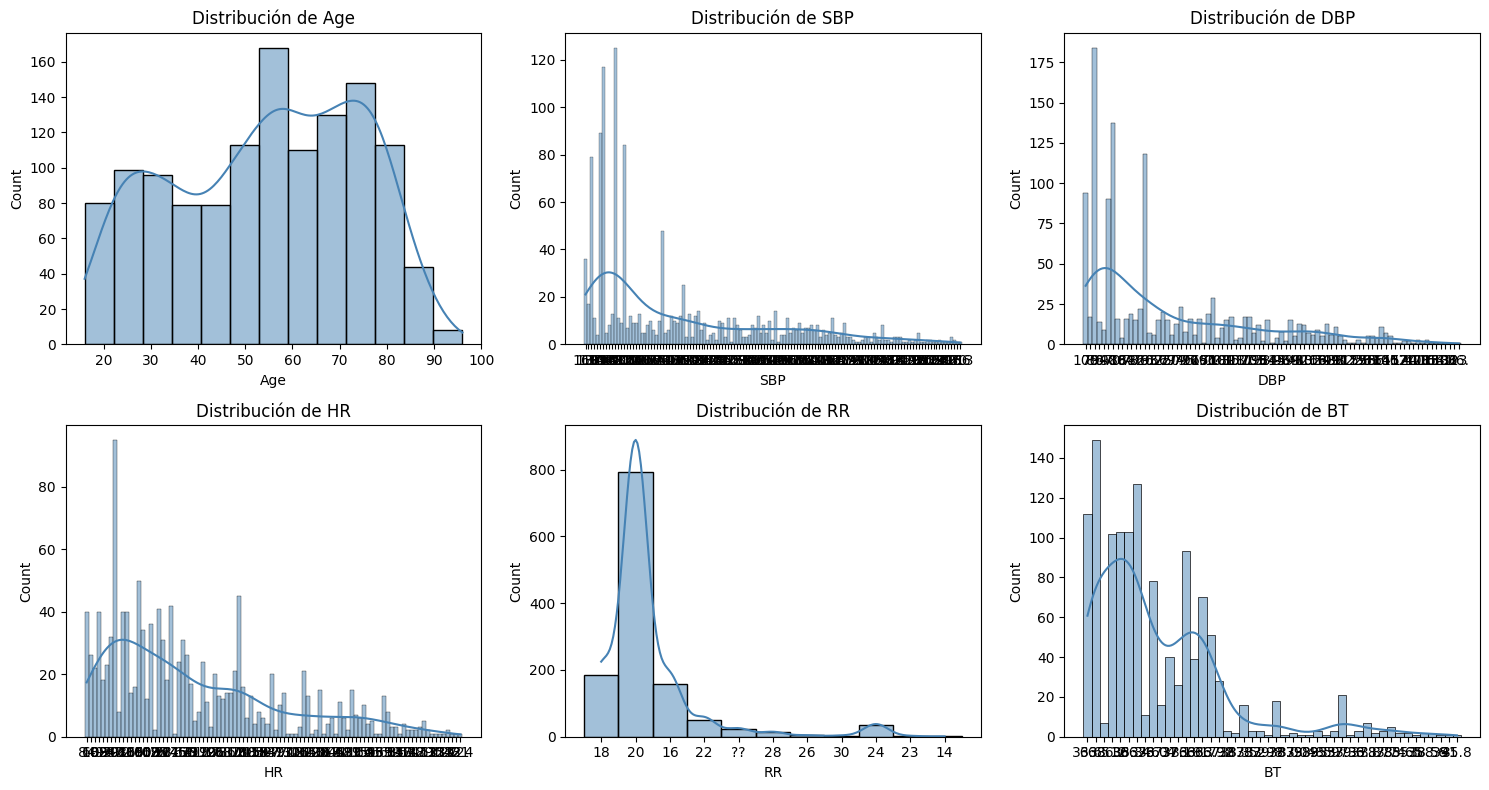

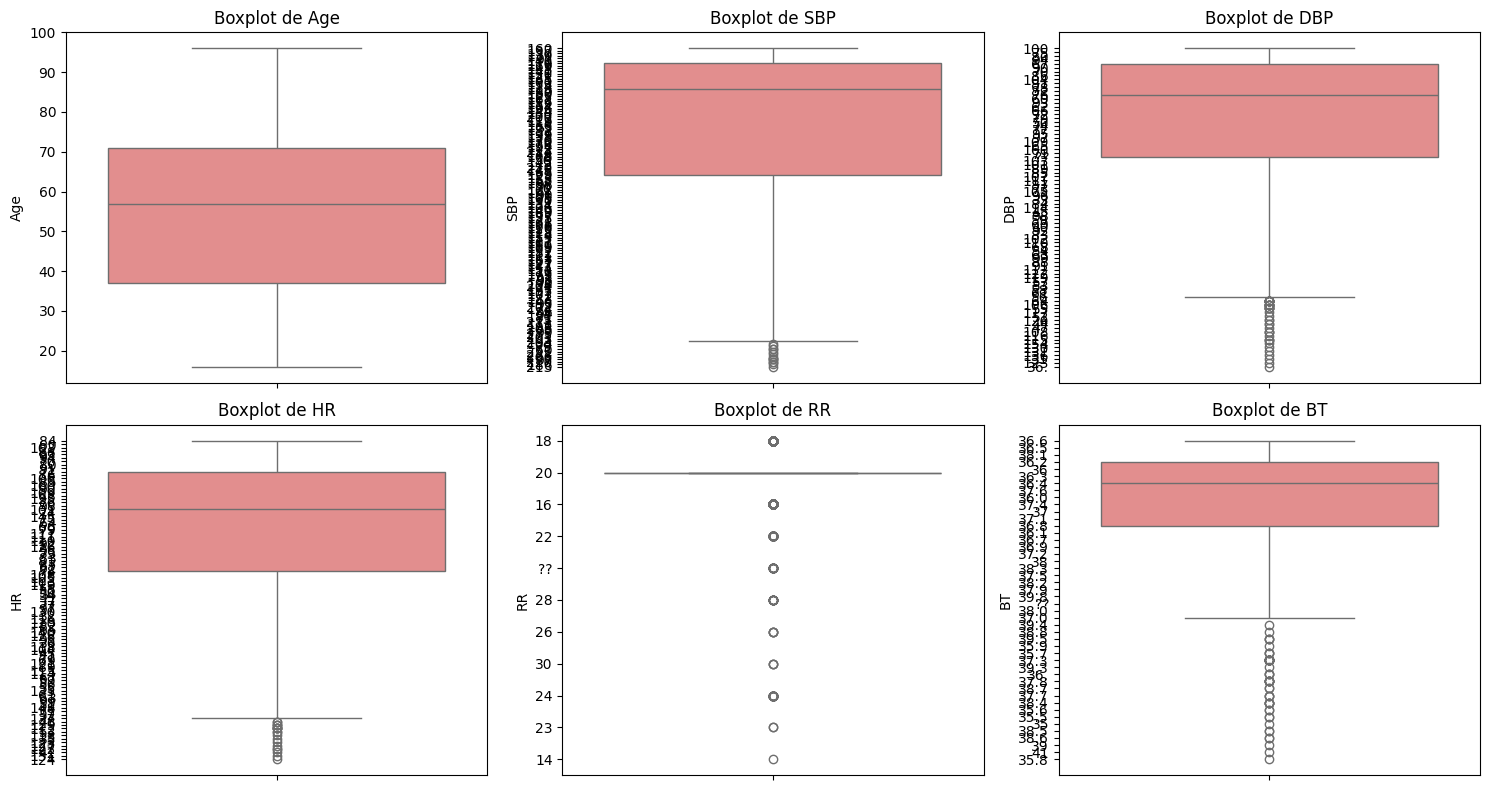

In [2]:
# =============== 4) Carga del dataset + EDA inicial ===============
DATA_PATH = "data/data.csv"  
df = pd.read_csv(DATA_PATH, encoding="latin-1", sep=";")

print("Dimensiones:", df.shape)
print("Columnas:", df.columns.tolist())
display(df.head(3))

# Estadística descriptiva
display(df.describe(include="all").T)

# =============================
# Gráficos iniciales: histogramas y boxplots de las variables predictoras
# =============================
import seaborn as sns
import matplotlib.pyplot as plt

# Lista preliminar de posibles predictoras (antes del feature engineering)
predictoras = ["Age","SBP","DBP","HR","RR","BT"]

# Histogramas
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(predictoras):
    sns.histplot(df[col], kde=True, ax=axes[i], color="steelblue")
    axes[i].set_title(f"Distribución de {col}")
plt.tight_layout()
plt.show()

# Boxplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(predictoras):
    sns.boxplot(y=df[col], ax=axes[i], color="lightcoral")
    axes[i].set_title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()



## Diccionario resumido (categóricas codificadas)

Sex: 1=Femenino, 2=Masculino

Injury: 1=No, 2=Sí

Pain: 0=No, 1=Sí

Mental: 1=Alert, 2=Verbal, 3=Pain response, 4=Unresponsive

Group: 1=Local ED (3°), 2=Regional ED (4°)

Arrival mode: 1=Walking, 2=Public Ambulance, 3=Private Vehicle, 4=Private Ambulance, 5–7=Other

KTAS_RN/KTAS_expert: 1–5 (1–3 emergencias; 4–5 no emergencias)

Disposition: 1=Discharge, 2=Ward, 3=ICU, 4= AMA Discharge, 5=Transfer, 6=Death, 7=Surgery.

In [3]:
# =============== 6) Conversión de tipos + ingeniería de atributos ===============
# A) Forzar a numérico variables mal tipadas
num_like = ["NRS_pain","SBP","DBP","HR","RR","BT","Saturation","KTAS duration_min"]
for col in num_like:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# B) Crear objetivo binario: Admitted (0=Egreso: {1,4,6}; 1=Ingreso: {2,3,5,7})
df["Admitted"] = df["Disposition"].apply(lambda x: 0 if x in [1,4,6] else 1)

# C) Feature engineering clínico
df["MAP"] = (df["SBP"] + 2*df["DBP"]) / 3
df["Hypotension"] = (df["SBP"] < 90).astype(int)
df["Tachycardia"] = (df["HR"] > 120).astype(int)
df["Resp_abnormal"] = ((df["RR"] < 12) | (df["RR"] > 24)).astype(int)
df["Fever_or_Hypothermia"] = ((df["BT"] > 38) | (df["BT"] < 35)).astype(int)
df["Elderly"] = (df["Age"] >= 65).astype(int)

print("Distribución Admitted:\n", df["Admitted"].value_counts())



Distribución Admitted:
 Admitted
0    832
1    435
Name: count, dtype: int64


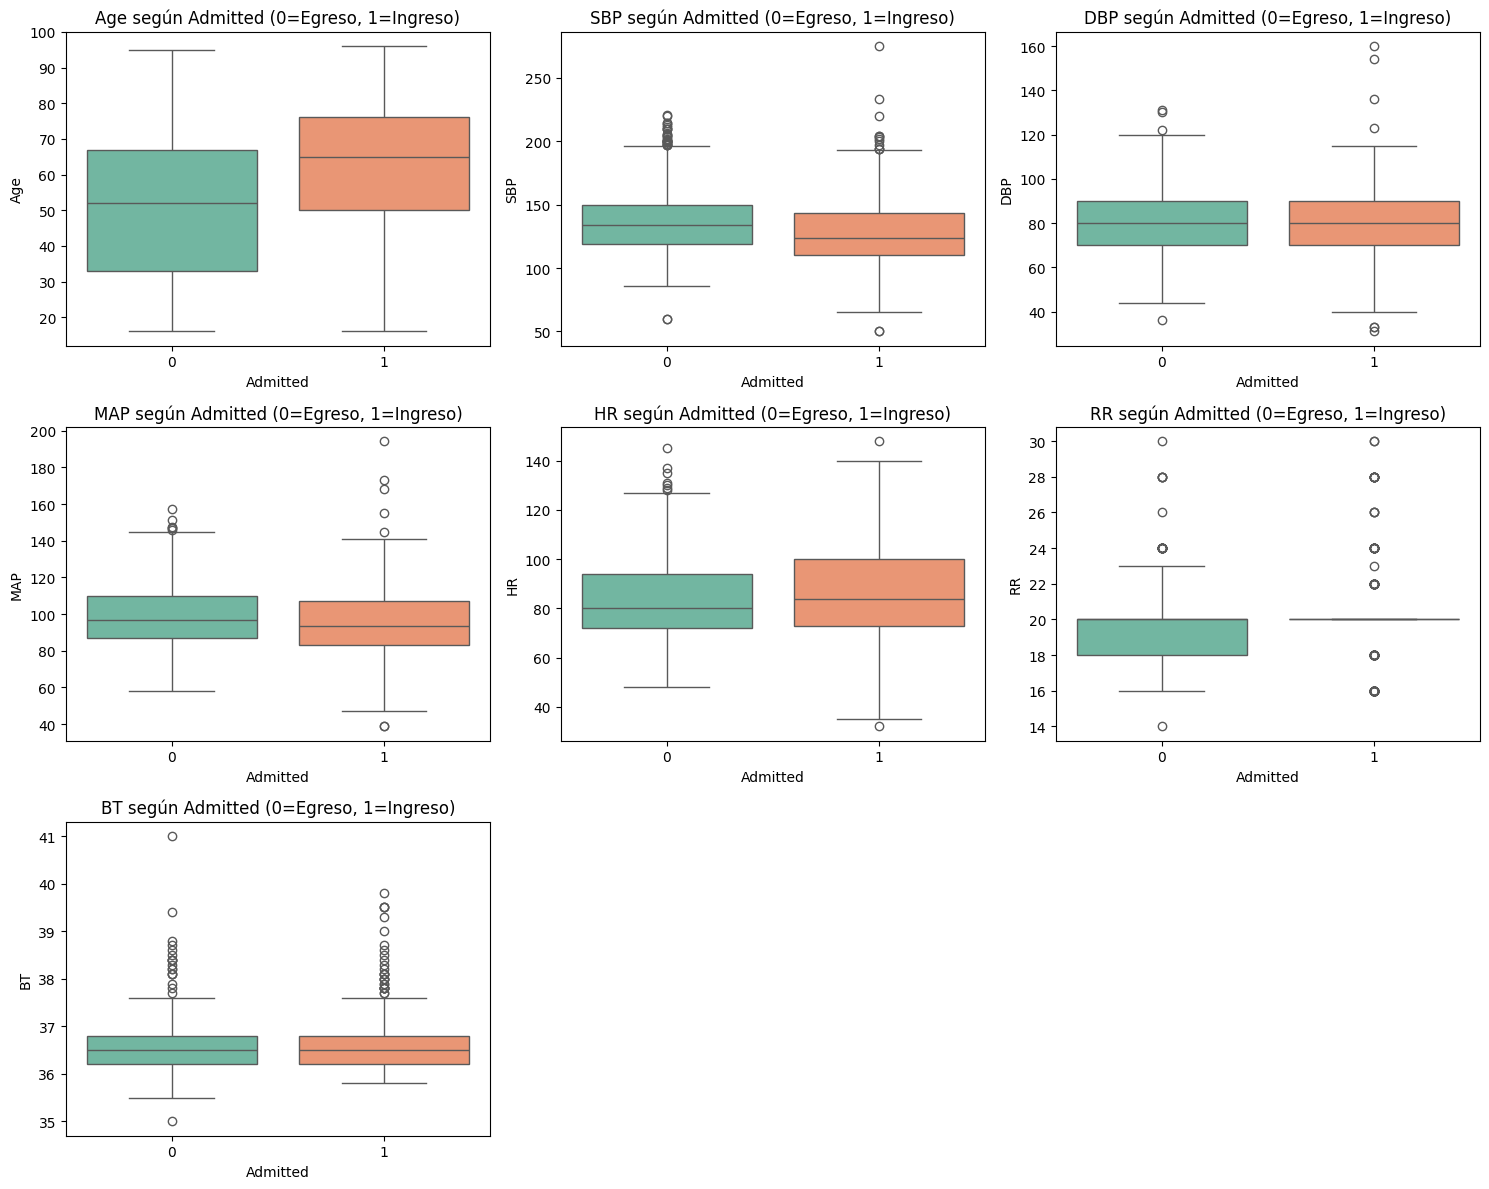

In [4]:
# =============== 7bis) Boxplots de predictoras vs Admitted ===============
import seaborn as sns

predictoras = ["Age","SBP","DBP","MAP","HR","RR","BT"]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # 9 espacios
axes = axes.flatten()

for i, col in enumerate(predictoras):
    sns.boxplot(x="Admitted", y=col, data=df, ax=axes[i], palette="Set2")
    axes[i].set_title(f"{col} según Admitted (0=Egreso, 1=Ingreso)")

# Eliminar ejes sobrantes
for j in range(len(predictoras), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## EDA breve y valores faltantes

Porcentaje de nulos en signos vitales (1–2%), Saturation (>50%) y KTAS duration_min (100%).

Decisión: descartar Saturation, KTAS duration_min, NRS_pain (nulos masivos).

Outliers: mantener por plausibilidad clínica (no winsorizamos).

Imputación con mediana en numéricas y moda en categóricas.

In [5]:
# =============== 8) Limpieza: descartar columnas con nulos masivos ===============
for dropcol in ["Saturation", "KTAS duration_min", "NRS_pain"]:
    if dropcol in df.columns:
        df.drop(columns=dropcol, inplace=True)

# Variables numéricas finales
num_vars = ['Age','SBP','DBP','MAP','HR','RR','BT',
            'Hypotension','Tachycardia','Resp_abnormal','Fever_or_Hypothermia','Elderly']

# Variables categóricas (codificadas con dígitos, pero tratadas como categorías)
cat_vars = ['Sex','Group','Arrival mode','Injury','Pain','Mental','KTAS_RN','KTAS_expert']

target = "Admitted"
X = df[num_vars + cat_vars].copy()
y = df[target].copy()

print("Num vars:", num_vars)
print("Cat vars:", cat_vars)


Num vars: ['Age', 'SBP', 'DBP', 'MAP', 'HR', 'RR', 'BT', 'Hypotension', 'Tachycardia', 'Resp_abnormal', 'Fever_or_Hypothermia', 'Elderly']
Cat vars: ['Sex', 'Group', 'Arrival mode', 'Injury', 'Pain', 'Mental', 'KTAS_RN', 'KTAS_expert']


## Partición de datos
Split 80/20 estratificado por Admitted (para mantener proporción de clases).

In [6]:
# =============== 10) Split y preprocesamiento ===============
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_vars),
    ("cat", cat_pipe, cat_vars)
])


## Modelo principal: Regresión Logística
Elegimos recall de Ingreso como métrica prioritaria (seguridad del paciente).
Reportamos: precision, recall, f1, accuracy y matriz de confusión.


              precision    recall  f1-score   support

           0       0.83      0.75      0.79       167
           1       0.59      0.70      0.64        87

    accuracy                           0.73       254
   macro avg       0.71      0.72      0.71       254
weighted avg       0.75      0.73      0.74       254



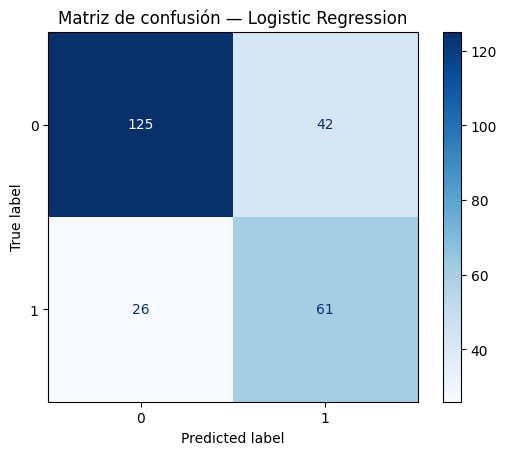

In [7]:
# =============== 12) Entrenamiento y evaluación ===============
log_reg = LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)

pipe_log = Pipeline([
    ("preproc", preprocessor),
    ("model", log_reg)
])

pipe_log.fit(X_train, y_train)
y_pred = pipe_log.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Matriz de confusión — Logistic Regression")
plt.show()


## PR/ROC + ajuste de umbral (clasificación)

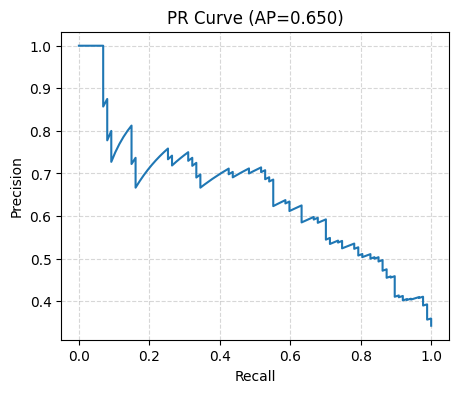

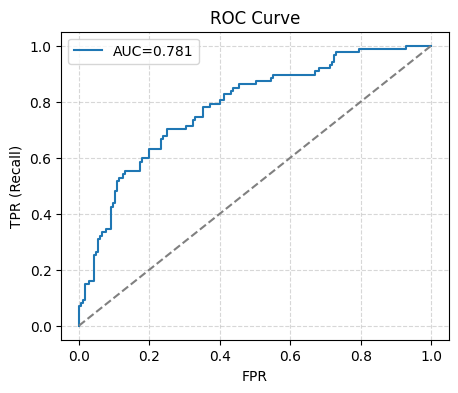

Umbral sugerido: 0.02 para recall≈0.8
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.34      1.00      0.51        87

    accuracy                           0.34       254
   macro avg       0.17      0.50      0.26       254
weighted avg       0.12      0.34      0.17       254



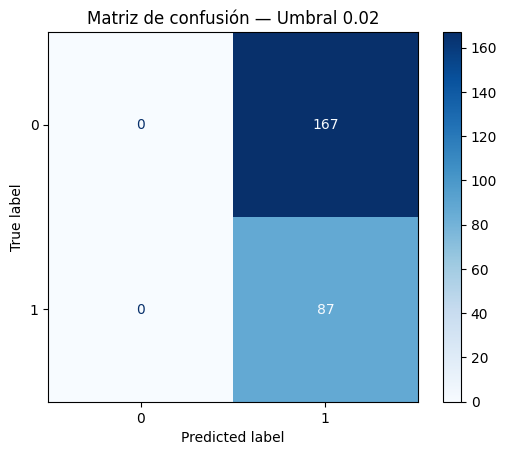

In [8]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Probabilidades del modelo
y_scores = pipe_log.predict_proba(X_test)[:, 1]

# Curva PR (preferible con clases desbalanceadas)
prec, rec, thr = precision_recall_curve(y_test, y_scores)
ap = auc(rec, prec)

plt.figure(figsize=(5,4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"PR Curve (AP={ap:.3f})")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Elegir umbral para maximizar recall de ingresos con precisión razonable
target_recall = 0.80  # ajusta a tu criterio clínico
best_thr = 0.5
for r, p, t in zip(rec, prec, np.r_[thr, 1.0]):
    if r >= target_recall:
        best_thr = t
        break

print(f"Umbral sugerido: {best_thr:.2f} para recall≈{target_recall}")
y_pred_thr = (y_scores >= best_thr).astype(int)
print(classification_report(y_test, y_pred_thr))
cm = confusion_matrix(y_test, y_pred_thr)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title(f"Matriz de confusión — Umbral {best_thr:.2f}")
plt.show()


## Curvas de aprendizaje (overfitting)

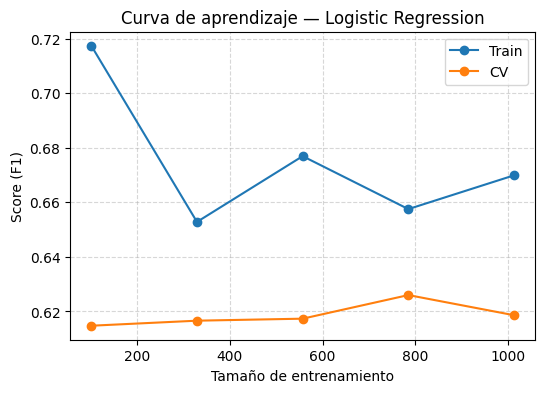

In [9]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipe_log,
    X=X, y=y,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=5,
    scoring="f1",  # o "recall" si priorizas recall
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, marker='o', label='Train')
plt.plot(train_sizes, val_mean, marker='o', label='CV')
plt.xlabel("Tamaño de entrenamiento")
plt.ylabel("Score (F1)")
plt.title("Curva de aprendizaje — Logistic Regression")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


## Búsqueda de hiperparámetros (GridSearch)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejores params: {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Mejor score CV (recall): 0.7185093167701864

=== Modelo con hiperparámetros óptimos (test) ===
              precision    recall  f1-score   support

           0       0.83      0.72      0.77       167
           1       0.57      0.71      0.63        87

    accuracy                           0.72       254
   macro avg       0.70      0.72      0.70       254
weighted avg       0.74      0.72      0.72       254



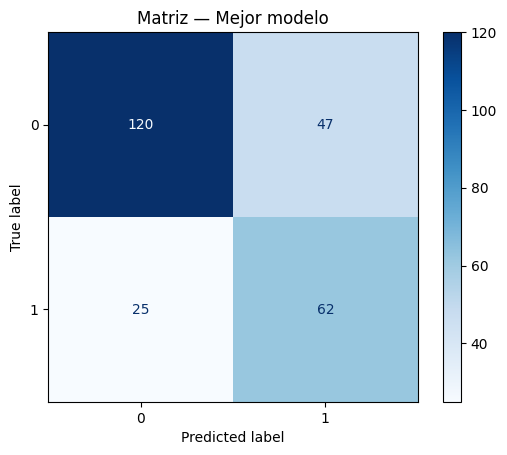

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "model__C": [0.01, 0.1, 1.0, 10.0],
    "model__penalty": ["l2"],           # "l1" requiere solver liblinear/saga
    "model__solver": ["lbfgs", "liblinear"]
}

grid = GridSearchCV(
    estimator=Pipeline([("preproc", preprocessor),
                        ("model", LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42))]),
    param_grid=param_grid,
    scoring="recall",   # prioriza recall en ingresos
    cv=5, n_jobs=-1, verbose=1
)

grid.fit(X_train, y_train)
print("Mejores params:", grid.best_params_)
print("Mejor score CV (recall):", grid.best_score_)

best_pipe = grid.best_estimator_
y_pred_best = best_pipe.predict(X_test)
print("\n=== Modelo con hiperparámetros óptimos (test) ===")
print(classification_report(y_test, y_pred_best))
cm = confusion_matrix(y_test, y_pred_best)
ConfusionMatrixDisplay(cm).plot(cmap="Blues"); plt.title("Matriz — Mejor modelo"); plt.show()


## Tabla comparativa de resultados (baseline vs mejor)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def get_metrics(y_true, y_pred, nombre):
    return {
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }

rows = []
# Baseline (pipe_log)
rows.append(get_metrics(y_test, y_pred, "LogReg baseline"))
# Mejor con grid
rows.append(get_metrics(y_test, y_pred_best, "LogReg best (grid)"))
# (Opcional) Con umbral ajustado:
rows.append(get_metrics(y_test, y_pred_thr, f"LogReg baseline (thr={best_thr:.2f})"))

res_df = pd.DataFrame(rows)
display(res_df)


,Modelo,Accuracy,Precision,Recall,F1
0,LogReg baseline,0.732283,0.592233,0.701149,0.642105
1,LogReg best (grid),0.716535,0.568807,0.712644,0.632653
2,LogReg baseline (thr=0.02),0.342520,0.342520,1.000000,0.510264


## Random Forest
Utilizado para comparar desempeño, finalmente se descarta, ya que modelo de regresión logística entrega mejor performance, sin embargo se prefirió también explorar esta alternativa.

🔹 Random Forest
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       167
           1       0.59      0.46      0.52        87

    accuracy                           0.70       254
   macro avg       0.67      0.65      0.65       254
weighted avg       0.69      0.70      0.69       254



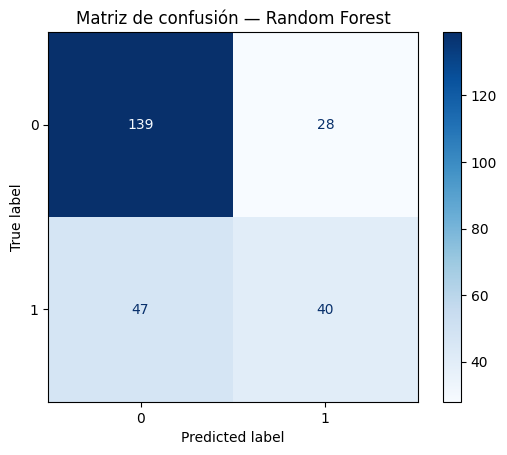

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Definir RF dentro del pipeline de preprocesamiento
pipe_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,        # número de árboles
        max_depth=None,          # sin límite, que crezca hasta pureza
        class_weight="balanced", # balancear clases
        random_state=42,
        n_jobs=-1
    ))
])

# Entrenar
pipe_rf.fit(X_train, y_train)

# Predecir
y_pred_rf = pipe_rf.predict(X_test)

# Reporte
print("🔹 Random Forest")
print(classification_report(y_test, y_pred_rf))

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm_rf).plot(cmap="Blues")
plt.title("Matriz de confusión — Random Forest")
plt.show()


## Comparación de ambos modelos

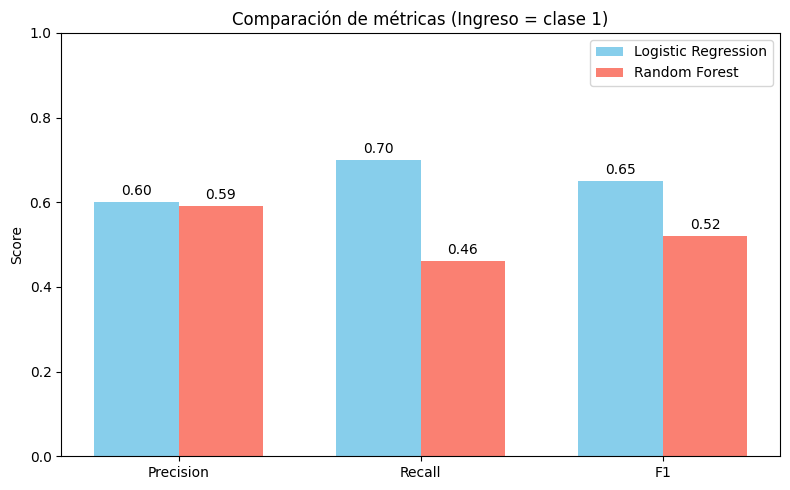

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Métricas obtenidas manualmente (Ingreso = clase 1)
results = {
    "Logistic Regression": {"precision": 0.60, "recall": 0.70, "f1": 0.65},
    "Random Forest": {"precision": 0.59, "recall": 0.46, "f1": 0.52}
}

# Preparar datos
models = list(results.keys())
metrics = ["precision", "recall", "f1"]

# Valores en forma de matriz
values = np.array([[results[m][metric] for metric in metrics] for m in models])

# Gráfico
x = np.arange(len(metrics))  # posiciones para cada métrica
width = 0.35  # ancho de barras

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, values[0], width, label="Logistic Regression", color="skyblue")
rects2 = ax.bar(x + width/2, values[1], width, label="Random Forest", color="salmon")

# Etiquetas y estilo
ax.set_ylabel("Score")
ax.set_title("Comparación de métricas (Ingreso = clase 1)")
ax.set_xticks(x)
ax.set_xticklabels([m.capitalize() for m in metrics])
ax.set_ylim(0,1)
ax.legend()

# Etiquetas encima de las barras
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),  # 3 pts arriba
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


## Interpretabilidad
Coeficientes en OR (exp(coef)). OR>1 → aumenta chance de ingreso; OR<1 la reduce.
Forest plot (escala log) y guardado en figs/.

,Variable,Coef,OddsRatio,logOR_abs
40,KTAS_expert_5,-1.285479,0.276518,1.285479
3,MAP,-1.071824,0.342384,1.071824
19,Arrival mode_4,0.860508,2.364360,0.860508
22,Arrival mode_7,-0.803406,0.447801,0.803406
34,KTAS_RN_4,-0.677041,0.508118,0.677041
35,KTAS_RN_5,-0.669542,0.511943,0.669542
14,Group_1,-0.640708,0.526919,0.640708
2,DBP,0.612809,1.845609,0.612809
32,KTAS_RN_2,0.570366,1.768914,0.570366
36,KTAS_expert_1,0.551282,1.735476,0.551282


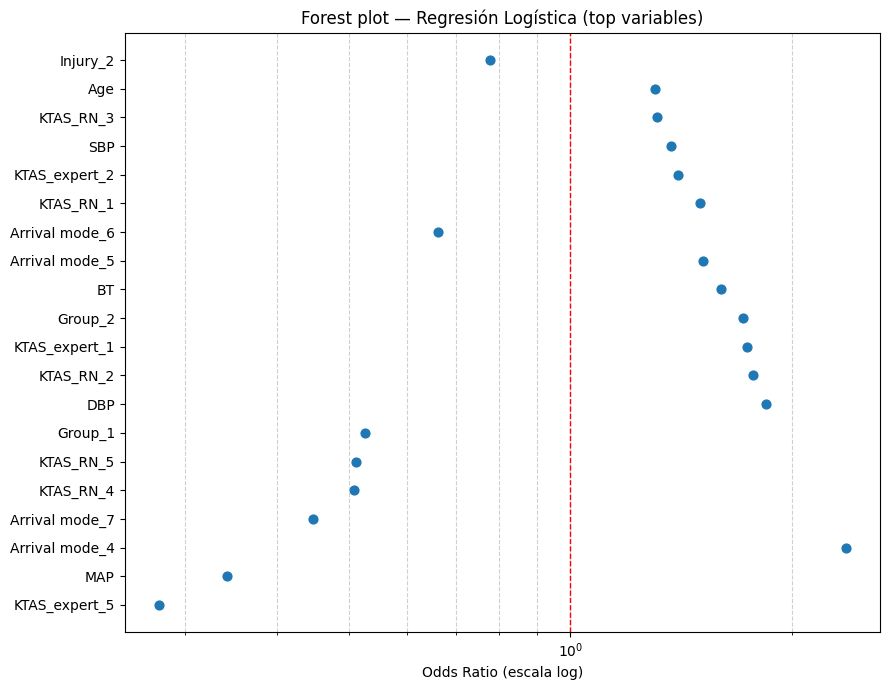

Guardado en: figs\forestplot_logreg_top20.png


In [14]:
# =============== 14) OR y forest plot ===============
from pathlib import Path

# Nombres de columnas después de OHE
ohe = pipe_log.named_steps['preproc'].named_transformers_['cat'].named_steps['onehot']
cat_out = ohe.get_feature_names_out(cat_vars).tolist()
feat_names = list(num_vars) + cat_out

# Coeficientes y OR
coefs = pipe_log.named_steps['model'].coef_[0]
odds = np.exp(coefs)

importance = pd.DataFrame({"Variable": feat_names, "Coef": coefs, "OddsRatio": odds})
importance["logOR_abs"] = np.abs(np.log(importance["OddsRatio"]))
imp_top = importance.sort_values("logOR_abs", ascending=False).head(20)

display(importance.sort_values("logOR_abs", ascending=False).head(10))

# Forest plot
outdir = Path("figs"); outdir.mkdir(parents=True, exist_ok=True)
fig, ax = plt.subplots(figsize=(9,7))
ypos = np.arange(len(imp_top))
ax.scatter(imp_top["OddsRatio"], ypos, s=40)
ax.axvline(1, color="red", linestyle="--", linewidth=1)
ax.set_yticks(ypos, labels=imp_top["Variable"])
ax.set_xscale("log")
ax.set_xlabel("Odds Ratio (escala log)")
ax.set_title("Forest plot — Regresión Logística (top variables)")
ax.grid(True, which="both", axis="x", linestyle="--", alpha=0.6)
fig.tight_layout()
save_path = outdir / "forestplot_logreg_top20.png"
fig.savefig(save_path, dpi=180, bbox_inches="tight")
plt.show()
print("Guardado en:", save_path)


## Verificación del escalado
Comprobamos que numéricas queden con media≈0 y desvío≈1 tras el preprocesamiento.

In [15]:
# =============== 16) Verificación del escalado (opcional) ===============
X_train_transformed = preprocessor.fit_transform(X_train)
all_feature_names = list(num_vars) + cat_out
X_train_df = pd.DataFrame(X_train_transformed, columns=all_feature_names)
X_train_df[num_vars].describe().T[['mean','std']]


,mean,std
Age,1.323938e-16,1.000494
SBP,2.595270e-16,1.000494
DBP,-1.753561e-17,1.000494
MAP,5.611394e-16,1.000494
HR,6.137462e-17,1.000494
RR,-1.683418e-16,1.000494
BT,-2.155126e-15,1.000494
Hypotension,-2.454985e-17,1.000494
Tachycardia,-2.630341e-17,1.000494
Resp_abnormal,1.052136e-17,1.000494


##  Validación del modelo 
A través de un subconjunto distinto del dataset original se realiza la validación del modelo según lo sugerido en clases sincrónicas.

In [16]:
# ============================================================
# Crear dataset de validación (60 filas reales) desde el dataset original
# - Mantiene TODAS las columnas tal cual están en el CSV original
# - Estratifica por "Admitted" (derivado de Disposition) para conservar proporciones
# - No agrega columnas nuevas al archivo de salida
# ============================================================

import pandas as pd
import numpy as np
from pathlib import Path

np.random.seed(42)

ORIG_PATH = "data/data.csv"                   # dataset original
VAL_OUT_PATH = "data/validation_patients.csv" # salida (idéntica estructura)
ENCODING = "latin-1"
SEP = ";"

# 1) Cargar dataset original
df_orig = pd.read_csv(ORIG_PATH, encoding=ENCODING, sep=SEP)
print("Dimensiones dataset original:", df_orig.shape)

# 2) Chequear columna Disposition
if "Disposition" not in df_orig.columns:
    raise ValueError("No se encontró la columna 'Disposition' en el dataset original.")

# 3) Construir Admitted SOLO para estratificar (no se guardará)
#    Regla clínica usada en el proyecto:
#    Egreso (0) = Disposition in [1, 4, 6]
#    Ingreso (1) = Disposition in [2, 3, 5, 7]
admit_map = df_orig["Disposition"].apply(lambda x: 0 if x in [1, 4, 6] else 1)
df_tmp = df_orig.copy()
df_tmp["_Admitted_tmp"] = admit_map

# 4) Tamaño del set de validación
N_VAL = 60

# 5) Calcular cuántas filas por clase para estratificar
class_counts = df_tmp["_Admitted_tmp"].value_counts().to_dict()
total = sum(class_counts.values())
prop_1 = class_counts.get(1, 0) / total if total > 0 else 0.5
n_1 = int(round(N_VAL * prop_1))
n_0 = N_VAL - n_1
# Seguridad por si alguna clase es muy escasa:
n_0 = min(n_0, (df_tmp["_Admitted_tmp"] == 0).sum())
n_1 = min(n_1, (df_tmp["_Admitted_tmp"] == 1).sum())
# Ajuste final por si no suman 60 (por redondeos/escasez):
while (n_0 + n_1) < N_VAL:
    # agrega a la clase con mayor disponibilidad
    if (df_tmp["_Admitted_tmp"] == 0).sum() - n_0 > (df_tmp["_Admitted_tmp"] == 1).sum() - n_1:
        n_0 += 1
    else:
        n_1 += 1
while (n_0 + n_1) > N_VAL:
    # quita de la clase con mayor asignación
    if n_0 > n_1 and n_0 > 0:
        n_0 -= 1
    elif n_1 > 0:
        n_1 -= 1
    else:
        break

print(f"Asignación estratificada -> Admitted=0: {n_0}, Admitted=1: {n_1} (total={n_0+n_1})")

# 6) Muestreo estratificado sin reemplazo
val_0 = df_tmp[df_tmp["_Admitted_tmp"] == 0].sample(n=n_0, random_state=42)
val_1 = df_tmp[df_tmp["_Admitted_tmp"] == 1].sample(n=n_1, random_state=42)
val_df = pd.concat([val_0, val_1], axis=0).sample(frac=1.0, random_state=42)  # mezclar

# 7) Remover columna temporal y mantener EXACTAMENTE las columnas originales
val_df = val_df[df_orig.columns]  # asegura el mismo orden/columnas del original

# 8) Guardar CSV con mismo encoding/separador
Path("data").mkdir(exist_ok=True, parents=True)
val_df.to_csv(VAL_OUT_PATH, index=False, encoding=ENCODING, sep=SEP)

print(f"✅ Dataset de validación creado y guardado en: {VAL_OUT_PATH}")
print("Dimensiones validación:", val_df.shape)
print("\nChequear primeras filas:")
display(val_df.head(5))

# (Opcional) Distribución de Disposition y Admitted en validación (para que la veas)
val_adm = val_df["Disposition"].apply(lambda x: 0 if x in [1,4,6] else 1)
print("\nDistribución en validación — Disposition:")
print(val_df["Disposition"].value_counts().sort_index())
print("\nDistribución en validación — Admitted (0=Egreso,1=Ingreso):")
print(val_adm.value_counts().sort_index())


Dimensiones dataset original: (1267, 24)
Asignación estratificada -> Admitted=0: 39, Admitted=1: 21 (total=60)
✅ Dataset de validación creado y guardado en: data/validation_patients.csv
Dimensiones validación: (60, 24)

Chequear primeras filas:


,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,...,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage
880,2,1,30,12,3,1,fever & chill,1,0,#BOÞ!,...,38.7,97,4,"Fever, unspecified",1,4,0,508,"4,00",0
1000,1,2,57,7,3,2,eyebrow laceration,1,0,#BOÞ!,...,36.8,NaN,4,Laceration of face,1,4,0,90,"10,47",0
693,2,2,51,8,3,2,"ocular pain, Rt.",1,1,6,...,36.3,98,4,Corneal abrasion,1,4,0,99,"4,00",0
947,2,1,48,6,2,1,Lt. hemiparesis,1,0,#BOÞ!,...,36.6,98,2,Cerebral infarction due to unspecified occlusi...,2,2,0,7889,"5,00",0
305,1,2,40,8,3,1,painful skin lesion,1,1,3,...,36.2,NaN,4,Herpes zoster,1,4,0,62,"3,65",0



Distribución en validación — Disposition:
Disposition
1    36
2    18
4     2
5     2
6     1
7     1
Name: count, dtype: int64

Distribución en validación — Admitted (0=Egreso,1=Ingreso):
Disposition
0    39
1    21
Name: count, dtype: int64


Dimensiones validación: (60, 24)
Columnas: ['Group', 'Sex', 'Age', 'Patients number per hour', 'Arrival mode', 'Injury', 'Chief_complain', 'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP', 'HR', 'RR', 'BT', 'Saturation', 'KTAS_RN', 'Diagnosis in ED', 'Disposition', 'KTAS_expert', 'Error_group', 'Length of stay_min', 'KTAS duration_min', 'mistriage']
🔹 Resultados en conjunto de validación (etiqueta desde Disposition):
              precision    recall  f1-score   support

           0      0.811     0.769     0.789        39
           1      0.609     0.667     0.636        21

    accuracy                          0.733        60
   macro avg      0.710     0.718     0.713        60
weighted avg      0.740     0.733     0.736        60



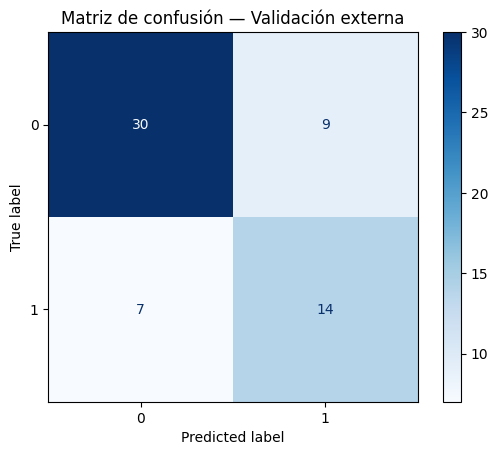

 Resultados guardados en: data/validation_predictions.csv


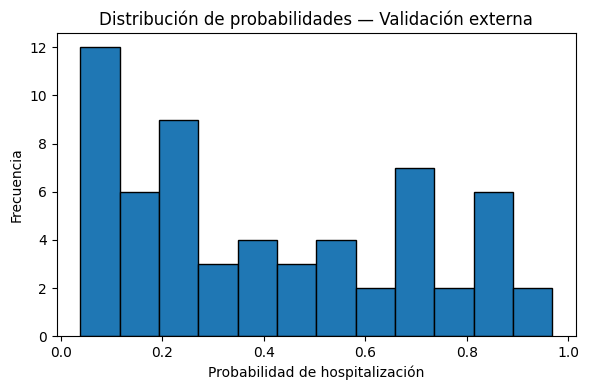

In [17]:
# ============================================================
# Validación:
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ---------- 0) Config ----------
VAL_PATH = "data/validation_patients.csv"   
SAVE_PRED_PATH = "data/validation_predictions.csv"

# ---------- 1) Carga robusta del CSV ----------
def load_validation_csv(path):
    tried = []
    for enc in ["latin-1", "utf-8"]:
        for sep in [";", ",", "\t"]:
            try:
                df = pd.read_csv(path, encoding=enc, sep=sep)
                # si tiene columnas plausibles, retornamos
                if "Age" in df.columns and ("SBP" in df.columns or "SBP " in df.columns):
                    return df
            except Exception as e:
                tried.append(f"encoding={enc}, sep='{sep}' -> {type(e).__name__}")
                continue
    raise FileNotFoundError(
        f"No pude leer {path} con intentos: " + " | ".join(tried)
    )

val_raw = load_validation_csv(VAL_PATH)
print("Dimensiones validación:", val_raw.shape)
print("Columnas:", val_raw.columns.tolist())

# ---------- 2) Normalizar nombres esperados ----------

val = val_raw.rename(columns={c: c.strip() for c in val_raw.columns})

# ---------- 3) Feature engineering clínico (idéntico a entrenamiento) ----------
def add_clinical_features(df):
    df = df.copy()
    # asegurar numéricas
    for col in ["SBP","DBP","HR","RR","BT","Age"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
        else:
            raise ValueError(f"Columna requerida ausente en validación: {col}")

    # MAP y flags
    df["MAP"] = (df["SBP"] + 2*df["DBP"]) / 3
    df["Hypotension"] = (df["SBP"] < 90).astype(int)
    df["Tachycardia"] = (df["HR"] > 120).astype(int)
    df["Resp_abnormal"] = ((df["RR"] < 12) | (df["RR"] > 24)).astype(int)
    df["Fever_or_Hypothermia"] = ((df["BT"] > 38) | (df["BT"] < 35)).astype(int)
    df["Elderly"] = (df["Age"] >= 65).astype(int)
    return df

val = add_clinical_features(val)

# ---------- 4) Construir objetivo 'Admitted' desde 'Disposition' ----------
# Regla usada en entrenamiento:
# Admitted = 0 (Egreso) si Disposition in [1,4,6]
# Admitted = 1 (Ingreso) si Disposition in [2,3,5,7]
if "Disposition" not in val.columns:
    raise ValueError("El set de validación no contiene 'Disposition'. Agrega esta columna para evaluar con etiqueta verdadera.")

val["Admitted"] = val["Disposition"].apply(lambda x: 0 if x in [1,4,6] else 1)

# ---------- 5) Definir listas de variables (si no están en memoria) ----------
try:
    num_vars
    cat_vars
except NameError:
    num_vars = ['Age','SBP','DBP','MAP','HR','RR','BT',
                'Hypotension','Tachycardia','Resp_abnormal','Fever_or_Hypothermia','Elderly']
    cat_vars = ['Sex','Group','Arrival mode','Injury','Pain','Mental','KTAS_RN','KTAS_expert']

# Verificar presencia de todas las columnas requeridas
missing_cols = [c for c in (num_vars + cat_vars) if c not in val.columns]
if missing_cols:
    raise ValueError(f"Faltan columnas requeridas en validación: {missing_cols}")

# ---------- 6) Seleccionar X_val / y_val ----------
X_val = val[num_vars + cat_vars].copy()
y_val = val["Admitted"].copy()

# ---------- 7) Predecir con el pipeline final ya entrenado (pipe_log) ----------
try:
    pipe_log
except NameError:
    raise NameError("No se encontró el pipeline entrenado 'pipe_log' en memoria. Ejecuta antes la celda donde se entrena la Regresión Logística.")

y_pred_val = pipe_log.predict(X_val)
y_prob_val = pipe_log.predict_proba(X_val)[:, 1]

# ---------- 8) Reporte y matriz de confusión ----------
print("🔹 Resultados en conjunto de validación (etiqueta desde Disposition):")
print(classification_report(y_val, y_pred_val, digits=3))

cm_val = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(cm_val)
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión — Validación externa")
plt.show()

# ---------- 9) Guardar resultados con probabilidades ----------
val_out = val.copy()
val_out["prob_ingreso"] = y_prob_val
val_out["pred_ingreso"] = y_pred_val
Path(SAVE_PRED_PATH).parent.mkdir(parents=True, exist_ok=True)
val_out.to_csv(SAVE_PRED_PATH, index=False, encoding="utf-8")
print(f" Resultados guardados en: {SAVE_PRED_PATH}")

# ---------- 10) (Opcional) Distribución de probabilidades ----------
plt.figure(figsize=(6,4))
plt.hist(y_prob_val, bins=12, edgecolor="k")
plt.xlabel("Probabilidad de hospitalización")
plt.ylabel("Frecuencia")
plt.title("Distribución de probabilidades — Validación externa")
plt.tight_layout()
plt.show()


## Limitaciones y posibles mejoras a futuro

Variables con nulos masivos descartadas (evitar sesgos).

Texto libre no modelado (Chief_complain, Diagnosis) → mejora futura con NLP/TF-IDF.

Clase 1 (Ingresos) menor que 0 → balance por class_weight="balanced".


